In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

trivial PR_T

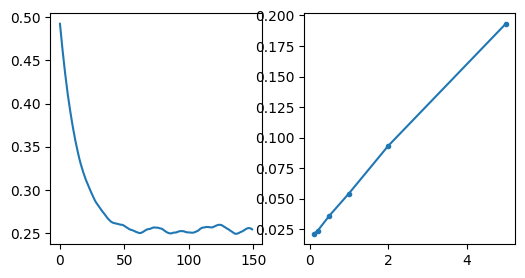

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 50
flip_n = 20
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.asarray([0.1, 0.2,0.5,1,2,5])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')

h_acov

In [3]:
def num_primitive_fct(num_function, baseline_idx, x_resolution, axis =-1):
  sum_left = jnp.cumsum(num_function, axis = axis) / x_resolution
  sum_right = jnp.cumsum(-num_function[..., ::-1], axis = axis)[..., ::-1] / x_resolution
  mean_sum = (sum_left + sum_right) / 2
  return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def num_integral_fct(num_function, x_resolution, axis =-1):
  sum_left = jnp.sum(num_function[..., :-1], axis = axis) / x_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = axis) / x_resolution
  return((sum_left + sum_right) / 2)

In [254]:
interval_len = 10
long_interval_len = 10 * interval_len
x_resolution = 100

zero_x_idx = int(interval_len / 2 * x_resolution)
x_idx_s = jnp.arange(interval_len * x_resolution)
x_s = x_idx_s / x_resolution - interval_len / 2

std_gau_s = 1/jnp.sqrt(2*jnp.pi) * jnp.exp(- x_s ** 2 /2)
def std_gau_fct(x):
  return(jnp.interp(x, x_s, std_gau_s, left = "extrapolate", right = "extrapolate"))
tanh_pri_s = num_primitive_fct(jnp.tanh(x_s), zero_x_idx, x_resolution)
def tanh_pri_fct(x):
  return(jnp.interp(x, x_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))

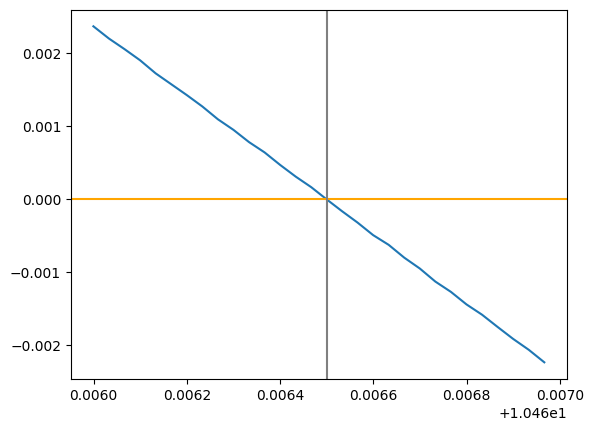

In [113]:
# determine stable init_h_acov
unscaled_std = 4.#1.9

# # phi(gh)
# init_h_acov_s_interval = jnp.asarray([0.6535,0.6545])
# init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
# init_potential_s = (-(init_h_acov_s ** 2 / 2)
#  +num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
#                                * std_gau_fct(x_s), 
#                                      x_resolution) / unscaled_std ** 2 
#  -num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
#                                * std_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2)
# init_h_acov = 0.65415#0.45903

# g phi
init_h_acov_s_interval = jnp.asarray([10.466,10.467])
init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
init_potential_s = (-(init_h_acov_s ** 2 / 2)
 +num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
                               * std_gau_fct(x_s), 
                                     x_resolution) * unscaled_std ** 2 
 -num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
                               * std_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2)
init_h_acov = 10.4665#1.65712

plt.plot(init_h_acov_s, init_potential_s)
plt.axhline(y = 0, color = 'orange')
plt.axvline(x = init_h_acov, color = 'gray')

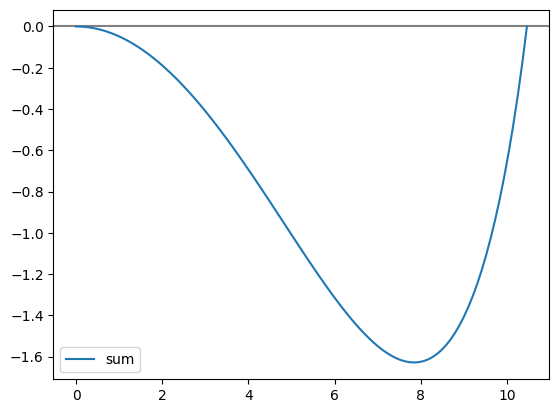

In [114]:
h_acov_step_n = x_resolution#100

h_acov_idx_s = jnp.arange(h_acov_step_n + 1)
h_acov_s = h_acov_idx_s / h_acov_step_n * init_h_acov

# # phi(g h)
# potential_s_1 = -(h_acov_s ** 2 / 2)
# potential_s_2 = num_integral_fct(
#     num_integral_fct(tanh_pri_fct(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                                   + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(std_gau_fct(x_s), 0),
#     x_resolution) / unscaled_std ** 2
# potential_s_3 = -num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(init_h_acov))
#                                * std_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2

# g phi(h)
potential_s_1 = -(h_acov_s ** 2 / 2)
potential_s_2 = num_integral_fct(
    num_integral_fct(tanh_pri_fct(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(std_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2
potential_s_3 = -num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(init_h_acov))
                               * std_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2

potential_s = potential_s_1 + potential_s_2 + potential_s_3
potential_s = potential_s - potential_s[0]
plt.axhline(y = 0, color = 'gray')
#plt.plot(h_acov_s, potential_s_1, label = "^2")
#plt.plot(h_acov_s, potential_s_2, label = "itg")
#plt.plot(h_acov_s, jnp.full(h_acov_s.shape, potential_s_3), label = "c")
plt.plot(h_acov_s, potential_s, label = "sum")
plt.legend()

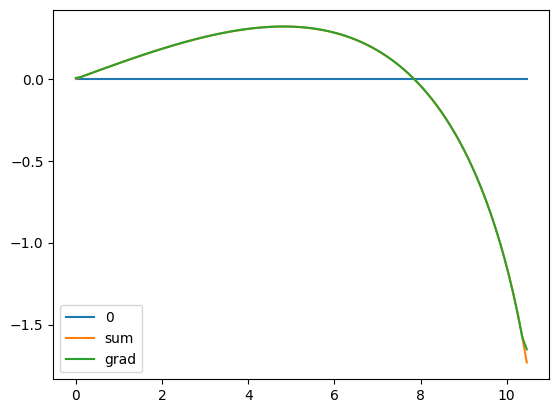

In [115]:
# # phi(g h)
# force_s_1 = h_acov_s 
# force_s_2 = -num_integral_fct(
#     num_integral_fct(jnp.tanh(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                               + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(std_gau_fct(x_s), 0),
#     x_resolution)

# g phi(h)
force_s_1 = h_acov_s 
force_s_2 = -num_integral_fct(
    num_integral_fct(jnp.tanh(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(std_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2

force_s = force_s_1 + force_s_2

plt.plot(h_acov_s, jnp.full(h_acov_s.shape, 0), label = "0")
# plt.plot(h_acov_s, force_s_2, label = "sum")
plt.plot(h_acov_s, force_s, label = "sum")
plt.plot(h_acov_s, -jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, label = "grad")
plt.legend()

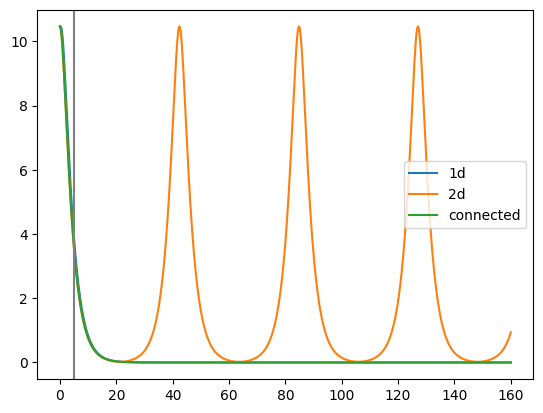

In [327]:
sim_len = 160 # affects f_max and leads to a neg error in ccov baseline
sim_resolution = 40

acov_lag_s = jnp.arange(sim_len * sim_resolution + 1)/sim_resolution

# separate 1d/2d
sim_interval = jnp.asarray([0,sim_len])

def h_acov_1d_velocity_fct(h_acov):
  return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2*potential_s, 0)), 
                    left = 0, right = "extrapolate"))
h_acov_traj_1d = traj_initializer(jnp.asarray(init_h_acov-0.00001), sim_interval, sim_resolution)
h_acov_traj_1d = jnp.insert(rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_1d, sim_interval, sim_resolution), 
                          0, init_h_acov)
plt.plot(acov_lag_s, h_acov_traj_1d, label = "1d")

def h_acov_2d_velocity_fct(pos_vel):
  return(jnp.asarray([pos_vel[1], jnp.interp(pos_vel[0], h_acov_s,-jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, 
                                             left = 0, right = "extrapolate")]))
h_acov_traj_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval, sim_resolution)
h_acov_traj_2d = jnp.insert(rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_2d, sim_interval, sim_resolution),
                          0, jnp.asarray([init_h_acov, 0]), axis = 1)
plt.plot(acov_lag_s, h_acov_traj_2d[0], label = "2d")

plt.legend()

# connected
connection_pos = 5

sim_interval_2d = jnp.asarray([0, connection_pos])
sim_interval_1d = jnp.asarray([connection_pos, sim_len])
def h_acov_2d_velocity_fct(pos_vel):
  return(jnp.asarray([pos_vel[1], jnp.interp(pos_vel[0], h_acov_s,-jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, 
                                             left = 0, right = "extrapolate")]))
def h_acov_1d_velocity_fct(h_acov):
  return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2*potential_s, 0)), 
                    left = 0, right = "extrapolate"))
h_acov_traj_c_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval_2d, sim_resolution)
h_acov_traj_c_2d = rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_c_2d, sim_interval, sim_resolution)
h_acov_traj_c_1d = traj_initializer(jnp.asarray(h_acov_traj_c_2d[0,-1]), sim_interval_1d, sim_resolution)
h_acov_traj_c_1d = rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_c_1d, sim_interval, sim_resolution)
h_acov_traj_c = jnp.concatenate([jnp.asarray([init_h_acov]), h_acov_traj_c_2d[0], h_acov_traj_c_1d])
plt.plot(acov_lag_s, 
         h_acov_traj_c, label = "connected")
plt.axvline(x = connection_pos, color = 'gray')
plt.legend()

ft and ccov

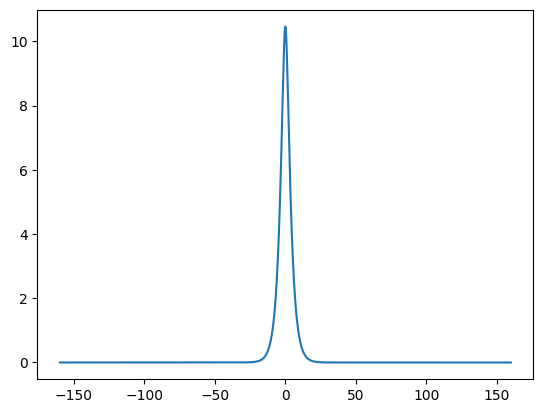

In [328]:
def mirror(traj, transformation = lambda x:x):
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), 
                          traj], axis = -1))

h_acov_traj_full = mirror(h_acov_traj_c)
acov_lag_s_full = mirror(acov_lag_s, lambda x:-x)
acov_zero_lag_idx = sim_len * sim_resolution + 1
plt.plot(acov_lag_s_full, h_acov_traj_full)

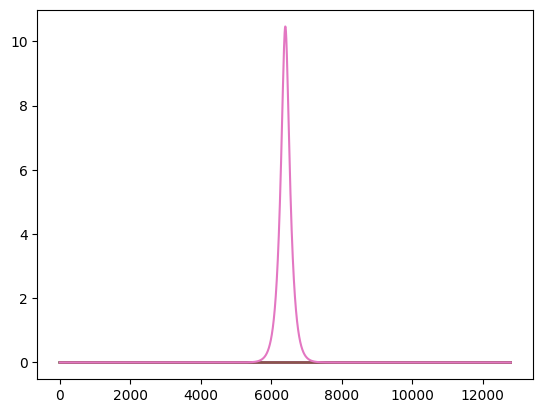

In [329]:
#negative frequencies, ft vs rft
def rft_mirror(rft, n=1):
  if n%2 ==1:
    output=jnp.concatenate([rft, jnp.conjugate(rft[::-1][:-1])], axis = -1)
  else:
    output=jnp.concatenate([rft, jnp.conjugate(rft[::-1][1:-1])], axis = -1)
  return(output)

#odd
odd_ft_n = sim_len * sim_resolution * 2 + 1
h_acov_traj_ft=jnp.fft.fft(h_acov_traj_full)
h_acov_traj_rft=jnp.fft.rfft(h_acov_traj_full)
h_acov_traj_rft_mirror=rft_mirror(h_acov_traj_rft)
ft_error = h_acov_traj_rft_mirror-h_acov_traj_ft
plt.plot(jnp.real(ft_error))
plt.plot(jnp.imag(ft_error))

h_acov_traj_ft_rec=jnp.fft.ifft(h_acov_traj_ft)
h_acov_traj_rft_rec=jnp.fft.irfft(h_acov_traj_rft,n=odd_ft_n) #irfft assumes even n
h_acov_traj_rft_mirror_rec=jnp.fft.ifft(h_acov_traj_rft_mirror)
plt.plot(jnp.real(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_mirror_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_mirror_rec-h_acov_traj_full))

#even
even_ft_n = sim_len * sim_resolution * 2 + 2
h_acov_traj_ft=jnp.fft.fft(h_acov_traj_full, n = even_ft_n)
h_acov_traj_rft=jnp.fft.rfft(h_acov_traj_full, n = even_ft_n)
h_acov_traj_rft_mirror=rft_mirror(h_acov_traj_rft,2)
ft_error = h_acov_traj_rft_mirror-h_acov_traj_ft
plt.plot(jnp.real(ft_error))
plt.plot(jnp.imag(ft_error))

h_acov_traj_ft_rec=jnp.fft.ifft(h_acov_traj_ft)[:-1]
h_acov_traj_rft_rec=jnp.fft.irfft(h_acov_traj_rft)[:-1]
h_acov_traj_rft_mirror_rec=jnp.fft.ifft(h_acov_traj_rft_mirror)[:-1]
plt.plot(jnp.real(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_mirror_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_mirror_rec-h_acov_traj_full))

#curve
plt.plot(h_acov_traj_full)

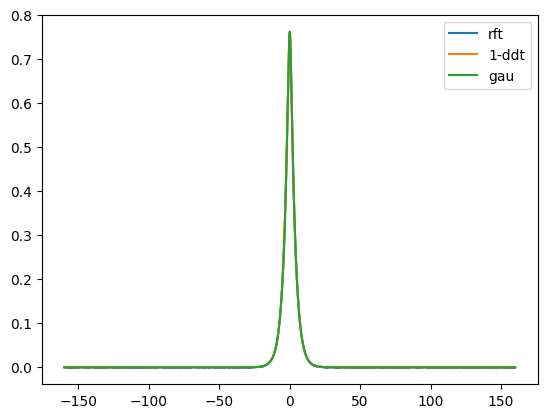

In [330]:
# r_acov
ft_n = sim_len * sim_resolution * 2 + 1
rft_n = jnp.ceil((ft_n + 1)/2).astype(int)
omega_s = 2 * jnp.pi * jnp.arange(rft_n)  / (2*sim_len)

r_acov_traj_full = jnp.fft.irfft(jnp.fft.rfft(h_acov_traj_full) 
                                   * (1+ omega_s**2) 
                                   / unscaled_std ** 2, n=ft_n)

plt.plot(acov_lag_s_full, r_acov_traj_full, label = "rft")
# plt.plot(acov_lag_s_full, jnp.fft.irfft(jnp.fft.fft(h_acov_traj_full) * (1+ omega_s**2) 
#                                    / unscaled_std ** 2, n=ft_n), label = "ft")
plt.plot(acov_lag_s_full, (h_acov_traj_full - jnp.gradient(jnp.gradient(h_acov_traj_full)) * sim_resolution **2)
                                   / unscaled_std ** 2, label = "1-ddt")
plt.plot(acov_lag_s_full, jnp.interp(h_acov_traj_full, h_acov_s, -force_s_2 / unscaled_std ** 2, left = 0), label="gau")

# # only positive tau
# half_ft_n = sim_len * sim_resolution + 1
# half_rft_n = jnp.ceil((half_ft_n + 1)/2).astype(int)
# omega_s = 2 * jnp.pi * jnp.arange(half_rft_n)  / sim_len
# plt.plot(acov_lag_s, jnp.fft.irfft(jnp.fft.rfft(h_acov_traj_c) * (1+ omega_s**2) 
#                                    / unscaled_std ** 2, n=half_ft_n), label = "half rft")

plt.legend()

0.012427359 4.7325206


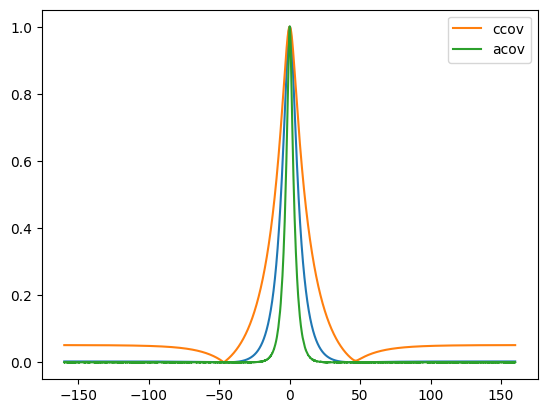

In [336]:
#r_ccov_sq
tanh_der_s = jnp.gradient(jnp.tanh(x_s))*x_resolution
def tanh_der_fct(x):
  return(jnp.interp(x, x_s, tanh_der_s, left = "extrapolate", right = "extrapolate"))

r_acov_traj_ft = (jnp.fft.rfft(h_acov_traj_full) * (1+ omega_s**2)
                  / unscaled_std ** 2)
temp_xx_s = (1+jax.lax.complex(0.,jnp.expand_dims(omega_s,1)))*(1+jax.lax.complex(0.,jnp.expand_dims(omega_s,0)))
mean_gain = num_integral_fct(tanh_der_fct(jnp.sqrt(init_h_acov) * x_s) * std_gau_fct(x_s), x_resolution)

r_ccov_sq = jnp.fft.irfft(jnp.fft.irfft(
  (jnp.abs(temp_xx_s/(temp_xx_s-unscaled_std**2 * mean_gain**2))**2-1)
  *jnp.expand_dims(r_acov_traj_ft, 1)*jnp.expand_dims(r_acov_traj_ft, 0),
  ft_n,0),ft_n,1) #rfft2 is false, see rfft2 doc
r_ccov_sq = r_ccov_sq-jnp.min(r_ccov_sq) # error due to finite len effect

# #record finite length effect
# fle_observation_len = 30
# fle_idx_s = acov_zero_lag_idx+jnp.arange(-fle_observation_len*sim_resolution, fle_observation_len*sim_resolution)
# fle_lag_s = acov_lag_s_full[fle_idx_s]
# fle_r_ccov_sq_320 = r_ccov_sq[fle_idx_s,fle_idx_s]

print(r_ccov_sq[0,0], r_ccov_sq[acov_zero_lag_idx,acov_zero_lag_idx])
plt.plot(acov_lag_s_full,jnp.einsum("ii->i",r_ccov_sq)/r_ccov_sq[acov_zero_lag_idx,acov_zero_lag_idx])
plt.plot(acov_lag_s_full,jnp.sqrt(jnp.einsum("ii->i",r_ccov_sq)/r_ccov_sq[acov_zero_lag_idx,acov_zero_lag_idx]),
         label= "ccov")
plt.plot(acov_lag_s_full,r_acov_traj_full/r_acov_traj_full[acov_zero_lag_idx], 
         label = "acov")
plt.legend()

In [335]:
print(r_ccov_sq[0,0],)

-0.0007563703 -0.013183729


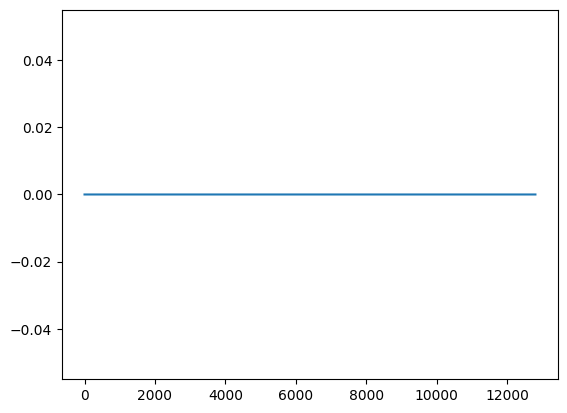

In [338]:
plt.plot(jnp.minimum(jnp.einsum("ii->i",r_ccov_sq),0))

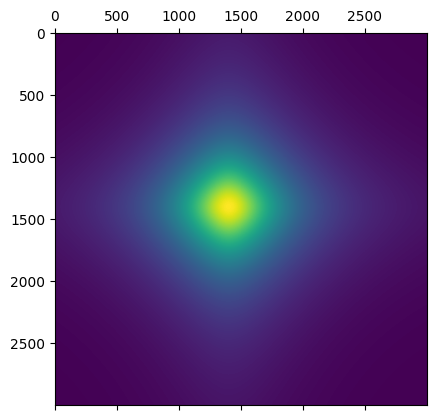

In [345]:
plt.matshow(r_ccov_sq[5000:8000,5000:8000])